In [1]:
import torch
import torch.nn as nn             #muntar xarxes (capes, activacions, backpropagació de gradients...)
import torch.optim as optim       #escollir optimitzador que recalcularà els pesos
import torch.nn.functional as F   #cridar directament a funcions sense acudir a les classes
#import torch.utils.data as data   #muntar dataloaders que generaran els batches de dades
from torch.utils.data import Dataset, DataLoader
import torchvision  #eines diverses per descarregar bases de dades, transformar dades...
from torch.utils.data import random_split

import matplotlib.pyplot as plt   #mostrar, plotejar, displayar dades i imatges
from tqdm import tqdm
import glob
import numpy as np
import cv2

In [2]:
batch_size =    5                 #per simplificar farem servir mateixa mida per training i test 
learning_rate = 0.01                #tasa d'aprenentatge
momentum =      0.1                  #paràmetre pel cas de l'optimitzador SGD (Stochastic gradient descent)
n_epochs =      100                  #vegades que la xarxa veurà totes les dades d'entrenament
criterium = nn.CrossEntropyLoss() #loss function 

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        #print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path[len(path):]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        #print(self.data)
        #for d in self.data:
        #    print(d)
        self.class_map = {"negativo" : 0, "positivo": 1, "tijeras": 2}
        self.img_dim = (480, 480)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        #return img_tensor, class_id
        #return img_tensor.float(), class_id.float()     # quizas necesario
        return img_tensor.float(), class_id
    
    def info(self):
        print(f"Classes: {self.class_map}")
        print(f"Length: {len(dataset)}")
        print(f"Root path: {self.imgs_path}")

In [4]:
dataset = CustomDataset("frames/")
dataset.info()

Classes: {'negativo': 0, 'positivo': 1, 'tijeras': 2}
Length: 61
Root path: frames/


In [5]:
train_data, test_data = random_split(dataset, [46, 15])
train_loader = DataLoader(train_data,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) #no_workers, pin_memory, drop_last

In [6]:
for imgs, labels in train_loader:
    print("Batch of images has shape: ",imgs.shape)
    print("Batch of labels has shape: ", labels.shape)

Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([5, 3, 480, 480])
Batch of labels has shape:  torch.Size([5, 1])
Batch of images has shape:  torch.Size([1, 3, 480, 480])
Batch o

torch.Size([3, 480, 480])


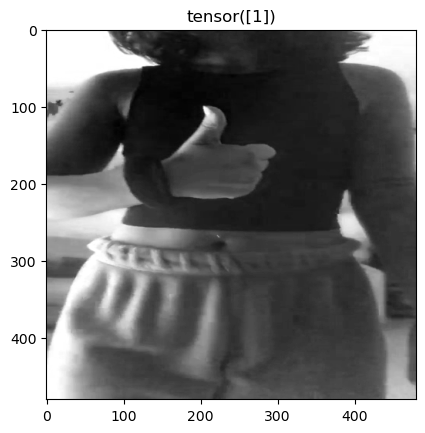

In [7]:
# exemple de mostra
idx = 3                       #un qualsevol per veure com són
input_example,target_example = train_data.__getitem__(idx)
print(input_example.size())       #mida de cada mostra/imatge/digit
plt.imshow(input_example[0,:,:], cmap='gray')
plt.title(str(target_example))
plt.show()

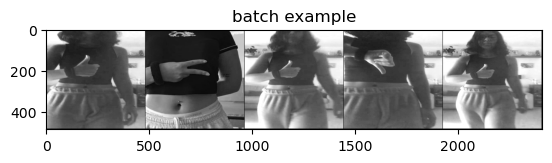

tensor([[1],
        [2],
        [1],
        [0],
        [1]])


In [8]:
# exemple de batch
dataiter = iter(train_loader)
batch_images_example, batch_labels_example = next(dataiter)

plt.imshow(torchvision.utils.make_grid(batch_images_example)[0,:,:], cmap='gray')
plt.title('batch example')
plt.show()
print(batch_labels_example)

In [9]:
# definició de la xarxa
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,40,5)   #def convolutonal layer (in_channels, out_channels, kernel_size)
        self.conv2 = nn.Conv2d(40,60,5)  #def convolutonal layer 
        self.fc1 = nn.Linear(821340,50)  #def fully connected layer
        self.fc2 = nn.Linear(50,3)      #def fully connected layer

    def forward(self, x):         #size [batch,channels,height,width] = [5,3,480,480]
        x = F.relu(self.conv1(x)) #size [5,3,476,476] padding effect
        x = F.max_pool2d(x,2)     #size [5,40,238,238] downsampling
        x = F.relu(self.conv2(x)) #size [5,60,234,234]   padding effect
        x = F.max_pool2d(x,2)     #size [5,60,117,117]   downsampling
        x = torch.flatten(x,1)    #flatten all dimensions except batch
        x = F.relu(self.fc1(x))   #size [5,821340]
        x = self.fc2(x)           #size [5,50]
        return x                  #size [5,3]  

In [10]:
# instanciació de la xarxa i l'optimitzador
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [11]:
# variables per graficar resultats
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
# definició dels bucles d'aprenentatge i test (validació)
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        target = target.resize(target.shape[0])
        loss = criterium(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:      #mostra log cada 100 batches
            print('epoch: {:2d} [{:5d}/{} ({:3.0f}%)]\tloss: {:.6f}'.format(
            epoch+1, batch_idx*len(data), len(train_loader.dataset),
            100.0*batch_idx/len(train_loader), loss.item()/batch_size))
            train_losses.append(loss.item()/batch_size)
            train_counter.append(batch_idx*batch_size+epoch*len(train_loader.dataset))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            target = target.resize(target.shape[0])
            #print(output)
            #print(target)
            test_loss += criterium(output, target)
            _,pred = torch.max(output.data,1)   
            correct += (pred == target).sum().item() 
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss.item())
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:5.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))    
    return correct  

In [13]:
# llencem els experiments
test()
for epoch in range(n_epochs):
  train(epoch)
  correct = test()

C:\Users\javie\anaconda3\envs\spyder-env\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")



Test set: Avg. loss: 1.309531, Accuracy: 8/15 (53.33%)

epoch:  1 [    0/46 (  0%)]	loss: 1.282262

Test set: Avg. loss: 0.214397, Accuracy: 8/15 (53.33%)

epoch:  2 [    0/46 (  0%)]	loss: 0.222640

Test set: Avg. loss: 0.214305, Accuracy: 8/15 (53.33%)

epoch:  3 [    0/46 (  0%)]	loss: 0.213725

Test set: Avg. loss: 0.214229, Accuracy: 8/15 (53.33%)

epoch:  4 [    0/46 (  0%)]	loss: 0.215697

Test set: Avg. loss: 0.214135, Accuracy: 8/15 (53.33%)

epoch:  5 [    0/46 (  0%)]	loss: 0.221720

Test set: Avg. loss: 0.213657, Accuracy: 8/15 (53.33%)

epoch:  6 [    0/46 (  0%)]	loss: 0.224501

Test set: Avg. loss: 0.213561, Accuracy: 8/15 (53.33%)

epoch:  7 [    0/46 (  0%)]	loss: 0.221065

Test set: Avg. loss: 0.213136, Accuracy: 8/15 (53.33%)

epoch:  8 [    0/46 (  0%)]	loss: 0.224996

Test set: Avg. loss: 0.212679, Accuracy: 8/15 (53.33%)

epoch:  9 [    0/46 (  0%)]	loss: 0.215958

Test set: Avg. loss: 0.212253, Accuracy: 8/15 (53.33%)

epoch: 10 [    0/46 (  0%)]	loss: 0.211636



Test set: Avg. loss: 0.208970, Accuracy: 8/15 (53.33%)

epoch: 83 [    0/46 (  0%)]	loss: 0.219163

Test set: Avg. loss: 0.209055, Accuracy: 8/15 (53.33%)

epoch: 84 [    0/46 (  0%)]	loss: 0.231732

Test set: Avg. loss: 0.208903, Accuracy: 8/15 (53.33%)

epoch: 85 [    0/46 (  0%)]	loss: 0.231994

Test set: Avg. loss: 0.208729, Accuracy: 8/15 (53.33%)

epoch: 86 [    0/46 (  0%)]	loss: 0.232325

Test set: Avg. loss: 0.208906, Accuracy: 8/15 (53.33%)

epoch: 87 [    0/46 (  0%)]	loss: 0.203753

Test set: Avg. loss: 0.208990, Accuracy: 8/15 (53.33%)

epoch: 88 [    0/46 (  0%)]	loss: 0.219046

Test set: Avg. loss: 0.209060, Accuracy: 8/15 (53.33%)

epoch: 89 [    0/46 (  0%)]	loss: 0.202254

Test set: Avg. loss: 0.209259, Accuracy: 8/15 (53.33%)

epoch: 90 [    0/46 (  0%)]	loss: 0.241548

Test set: Avg. loss: 0.209336, Accuracy: 8/15 (53.33%)

epoch: 91 [    0/46 (  0%)]	loss: 0.202629

Test set: Avg. loss: 0.209526, Accuracy: 8/15 (53.33%)

epoch: 92 [    0/46 (  0%)]	loss: 0.216738



Test set: Avg. loss: 0.209276, Accuracy: 8/15 ( 53%)



<function matplotlib.pyplot.show(close=None, block=None)>

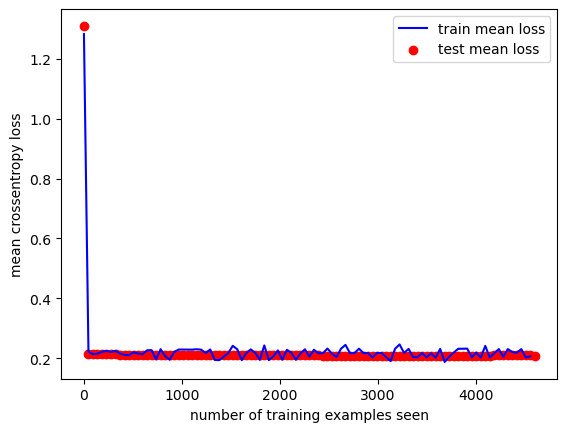

In [14]:
# mostrem els resultats
print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:3.0f}%)\n'.format(
    test_losses[-1], correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))     

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')

plt.scatter(test_counter, test_losses, color='red')
plt.legend(['train mean loss', 'test mean loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('mean crossentropy loss')
plt.show